import standard libraries

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import text preprocessing libraries

In [97]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import re

import feature extraction, modeling and evaluation libraries

In [120]:
# feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


# models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#pipeline
from sklearn.pipeline import make_pipeline

import train and test data

In [99]:
df_train = pd.read_csv(r'C:\Users\BalintStewart\OneDrive - Health Data Research\Desktop\magnimind-assignments\NLP\kaggle_sentiment_analysis\data\train.csv', encoding= 'latin1')
df_train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [100]:
df_test = pd.read_csv(r'C:\Users\BalintStewart\OneDrive - Health Data Research\Desktop\magnimind-assignments\NLP\kaggle_sentiment_analysis\data\test.csv', encoding= 'latin1')
df_test.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


# Some basic EDA to get a feel for the data

In [101]:
df_train.shape, df_test.shape

((27481, 10), (4815, 9))

In [102]:
df_test.isna().sum()

textID              1281
text                1281
sentiment           1281
Time of Tweet       1281
Age of User         1281
Country             1281
Population -2020    1281
Land Area (Km²)     1281
Density (P/Km²)     1281
dtype: int64

In [103]:
df_test[df_test.isna()].sample(10)

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
1303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
df_train.isna().sum()

textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [105]:
df_train.dropna(inplace = True)
df_test.dropna(inplace = True)

In [106]:
df_train.shape, df_test.shape

((27480, 10), (3534, 9))

What is the 'train' 'test' split in my data, now that I've dropped a bunch of NA values from the test.csv data?

In [107]:
3534 /27480

0.12860262008733625

87/13 split seems a little too much, may skew evaluation of my models because of small test set. Will combine both train (minus 'selected_text' column which is missing in 'test') into a single dataset and do train_test_split instead on this bigger dataset.

In [108]:
# Drop selected_text column from df_train so that concat works for all cols
df_train.drop('selected_text', axis = 1, inplace=True)
df_train.columns

Index(['textID', 'text', 'sentiment', 'Time of Tweet', 'Age of User',
       'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)'],
      dtype='object')

In [109]:
# Combine the two datasets, and then create my own train test split
df = pd.concat([df_train, df_test])
df.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative,noon,21-30,Albania,2877797.0,27400.0,105.0
2,088c60f138,my boss is bullying me...,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,9642c003ef,what interview! leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0


Check if the target variable is balanced

Text(0.5, 1.0, 'sentiment count')

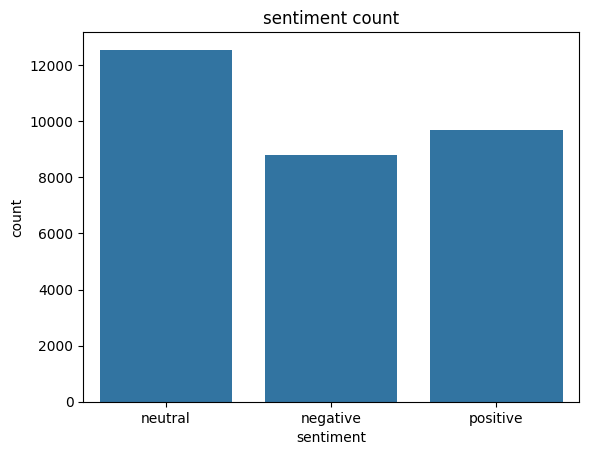

In [110]:

sns.countplot(x = df['sentiment'], data = df)
plt.xlabel('sentiment')
plt.title('sentiment count')

Sentiment data is quite well balanced across the three classes

Are features such as time of tweet, or age of user, affecting sentiment?

Text(0.5, 1.0, 'Sentiment distribution by Time of Tweet')

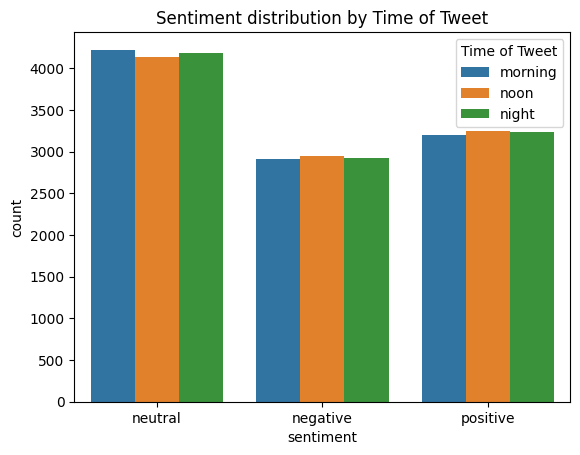

In [111]:
sns.countplot(x = 'sentiment', data = df, hue = 'Time of Tweet')
plt.title('Sentiment distribution by Time of Tweet')

Text(0.5, 1.0, 'Sentiment distribution by age of user')

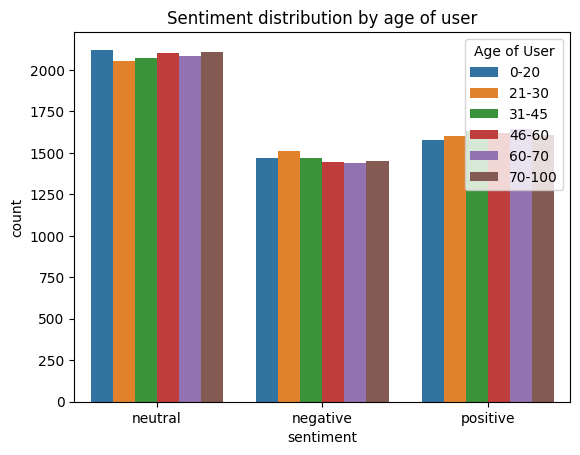

In [112]:
sns.countplot(x = 'sentiment', hue= 'Age of User', data = df )
plt.title('Sentiment distribution by age of user')

# Preprocessing the data 

Standard text cleaning to include lower casing, removing URLs, punctuation, mentions and hashtages.
Then perform lemmatization, better than stemming this case as lemmatization retains more of the original meaning, rather than using eg. lancaster stemmer which uses aggressive rules to trim suffixes of words

In [113]:
# Initiaize the lemmatizer, stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [114]:
# Write function to clean text
def clean_text(text):
    text = text.lower() # lowercase the text data
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags= re.MULTILINE) # remove URLs from the data
    text = re.sub(r'\@\w+|\#', '', text) # remove mentions/hastags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Remove stopwords and lemmatize
    return text

In [115]:
# Apply the cleaning function to the 'text' column
df['cleaned_text'] = df['text'].apply(lambda x: clean_text(str(x)))

# Display a sample of the cleaned text to verify
df[['text', 'cleaned_text']].head()

,text,cleaned_text
0,"I`d have responded, if I were going",id responded going
1,Sooo SAD I will miss you here in San Diego!!!,sooo sad miss san diego
2,my boss is bullying me...,bos bullying
3,what interview! leave me alone,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",son couldnt put release already bought


# Transform text data into numerical features for model training, try a few different models

Will use tf-idf for vectorisation. This approach takes into account word frequency across the corpus rather than simple count matrix, commone words across the corpus weighted lower

In [116]:
# Split the concatenated data into train and test splits
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'],  df['sentiment'], random_state =42)

In [117]:
# Vectorise the train data
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)

#fit the vectoriser on the test data
X_test_tfidf = tfidf.transform(X_test)

In [118]:
# Define the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=200, random_state=42),
    "Support Vector Machine": SVC(kernel='linear', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": MultinomialNB()
}

# Dictionary to store performance metrics
performance = {}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_tfidf, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_tfidf)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # Store performance
    performance[model_name] = {
        "Accuracy": accuracy,
        "Classification Report": report,
        "Confusion Matrix": cm
    }
    
    # Print performance
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"Classification Report for {model_name}:\n{report}")
    print(f"Confusion Matrix for {model_name}:\n{cm}")

Logistic Regression Accuracy: 0.6897
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

    negative       0.71      0.58      0.64      2162
     neutral       0.63      0.75      0.68      3151
    positive       0.78      0.71      0.74      2441

    accuracy                           0.69      7754
   macro avg       0.71      0.68      0.69      7754
weighted avg       0.70      0.69      0.69      7754

Confusion Matrix for Logistic Regression:
[[1250  792  120]
 [ 413 2361  377]
 [  88  616 1737]]
Support Vector Machine Accuracy: 0.7096
Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

    negative       0.73      0.60      0.66      2162
     neutral       0.65      0.77      0.70      3151
    positive       0.79      0.73      0.76      2441

    accuracy                           0.71      7754
   macro avg       0.72      0.70      0.71      7754
weighted avg       0.7

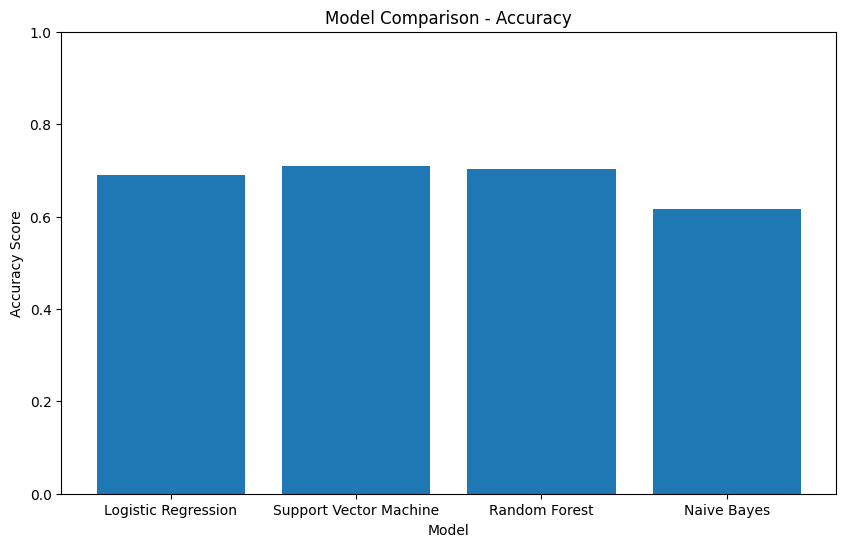

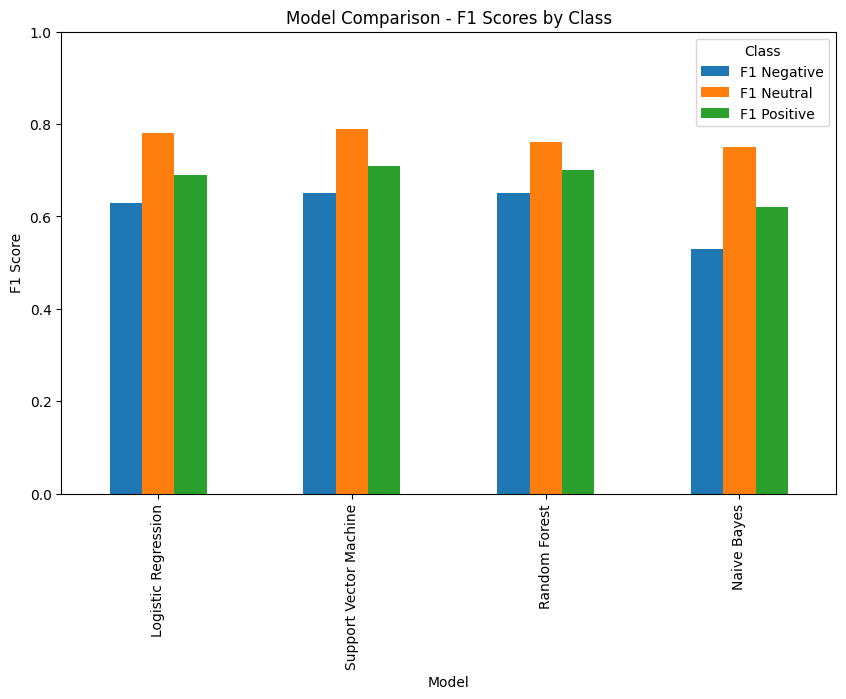

In [126]:
# Extract metrics for visualization
accuracy_scores = [performance[model]["Accuracy"] for model in models.keys()]
f1_scores_negative = [performance[model]["Classification Report"].split()[10] for model in models.keys()]
f1_scores_neutral = [performance[model]["Classification Report"].split()[15] for model in models.keys()]
f1_scores_positive = [performance[model]["Classification Report"].split()[20] for model in models.keys()]

model_names = list(models.keys())

# Convert F1-scores from strings to floats
f1_scores_negative = list(map(float, f1_scores_negative))
f1_scores_neutral = list(map(float, f1_scores_neutral))
f1_scores_positive = list(map(float, f1_scores_positive))

df_metrics = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracy_scores,
    "F1 Negative": f1_scores_negative,
    "F1 Neutral": f1_scores_neutral,
    "F1 Positive": f1_scores_positive
})

# Plot Accuracy Scores
plt.figure(figsize=(10, 6))
plt.bar(df_metrics["Model"], df_metrics["Accuracy"])
plt.title("Model Comparison - Accuracy")
plt.xlabel("Model")
plt.ylabel("Accuracy Score")
plt.ylim(0, 1)
plt.show()

# Plot F1 Scores for each class
df_metrics.plot(x="Model", y=["F1 Negative", "F1 Neutral", "F1 Positive"], kind="bar", figsize=(10, 6))
plt.title("Model Comparison - F1 Scores by Class")
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.legend(title="Class")
plt.show()

Logistic regression, SVM and Random Forest all performing well. Try fine-tuning these

In [ ]:
# Fine-tune logistic regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=200, random_state=42), param_grid_lr, cv=5, scoring='accuracy')
grid_lr.fit(X_train_tfidf, y_train)
print(f"Best Logistic Regression parameters: {grid_lr.best_params_}")
print(f"Best Logistic Regression accuracy: {grid_lr.best_score_}")

Best Logistic Regression parameters: {'C': 1, 'solver': 'lbfgs'}
Best Logistic Regression accuracy: 0.68061049011178


In [124]:
# Fine-tune SVM
# param_grid_svm = {
#    'C': [0.1, 1, 10],
#    'kernel': ['linear', 'rbf']
#}

#grid_svm = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=5, scoring='accuracy')
#grid_svm.fit(X_train_tfidf, y_train)
#print(f"Best SVM parameters: {grid_svm.best_params_}")
#print(f"Best SVM accuracy: {grid_svm.best_score_}")

In [ ]:
# Fine tune a random forest
# Define the parameter grid for Random Forest
# param_grid = {
#    'n_estimators': [50, 100, 200],            # Number of trees
#   'max_depth': [None, 10, 20, 30],           # Maximum depth of each tree
#  'min_samples_split': [2, 5, 10],           # Minimum samples to split a node
#    'min_samples_leaf': [1, 2, 4],             # Minimum samples for a leaf node
#    'max_features': ['auto', 'sqrt', 'log2']   # Number of features to consider when looking for the best split
#}

# Initialize the Random Forest model
#rf_model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV with cross-validation
#grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV to the training data
#grid_search.fit(X_train_tfidf, y_train)

# Print the best parameters and best accuracy score
#print("Best Parameters:", grid_search.best_params_)
#print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\BalintStewart\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
195 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\BalintStewart\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\BalintStewart\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\BalintStewart\AppData\Local\Programs\Python\Python3

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.6984952708512469


Best Logistic Regression parameters: {'C': 1, 'solver': 'lbfgs'}
Best Logistic Regression accuracy: 0.68061049011178

Best SVM parameters: {'C': 1, 'kernel': 'linear'}
Best SVM accuracy: 0.6918314703353396

Best RF Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best RF Cross-Validation Accuracy: 0.6984952708512469

Compare fine-tuned performance on the test data

In [139]:
# Initialise fine-tuned models
models = {'Logistic regression': LogisticRegression(C = 1, solver = 'lbfgs',random_state=42),
          'Support vector machine': SVC(C = 1, kernel = 'linear'),
          'Random Forest': RandomForestClassifier(max_depth = None, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 2, n_estimators = 200)
          }                                                                                      

#initialise dictionary to store evaluation scores
performance = {}

# train and evaluate each of the optimised models

for model_name, model in models.items():
    # train the mode;
    model.fit(X_train_tfidf, y_train)
    # predict on test data
    y_pred = model.predict(X_test_tfidf)

    # gather evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # store the performance metrics
    performance[model_name] = {'Accuracy': accuracy,
                               'Classification report': report,
                               'Confusion matrix': cm}
    
        # Print the performance for each model
    print(f"\n{model_name} Test Accuracy: {accuracy:.4f}")
    print(f"Classification Report for {model_name}:\n{report}")
    print(f"Confusion Matrix for {model_name}:\n{cm}")


Logistic regression Test Accuracy: 0.6897
Classification Report for Logistic regression:
              precision    recall  f1-score   support

    negative       0.71      0.58      0.64      2162
     neutral       0.63      0.75      0.68      3151
    positive       0.78      0.71      0.74      2441

    accuracy                           0.69      7754
   macro avg       0.71      0.68      0.69      7754
weighted avg       0.70      0.69      0.69      7754

Confusion Matrix for Logistic regression:
[[1250  792  120]
 [ 413 2361  377]
 [  88  616 1737]]

Support vector machine Test Accuracy: 0.7096
Classification Report for Support vector machine:
              precision    recall  f1-score   support

    negative       0.73      0.60      0.66      2162
     neutral       0.65      0.77      0.70      3151
    positive       0.79      0.73      0.76      2441

    accuracy                           0.71      7754
   macro avg       0.72      0.70      0.71      7754
weighted a

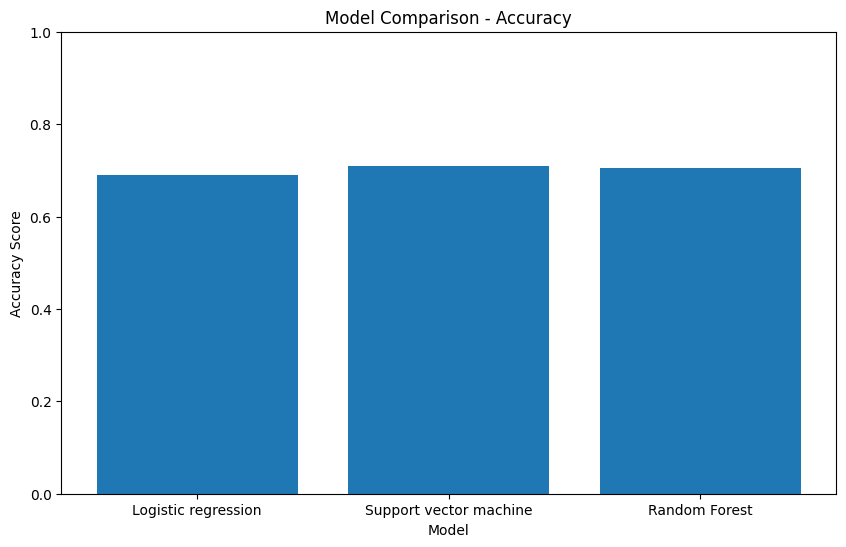

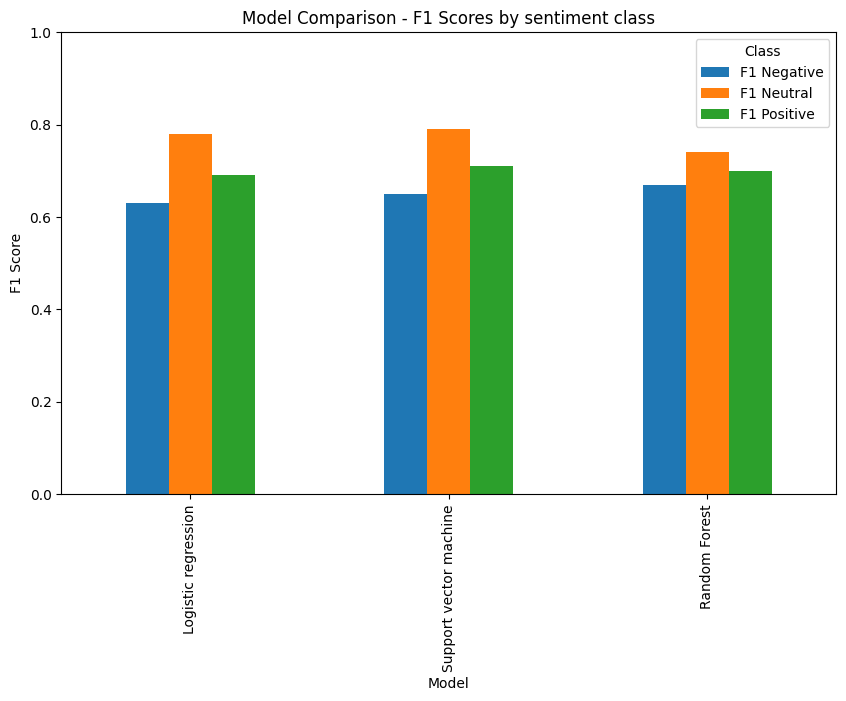

In [144]:
# Extract metrics for visualization
accuracy_scores = [performance[model]["Accuracy"] for model in models.keys()]
f1_scores_negative = [performance[model]["Classification report"].split()[10] for model in models.keys()]
f1_scores_neutral = [performance[model]["Classification report"].split()[15] for model in models.keys()]
f1_scores_positive = [performance[model]["Classification report"].split()[20] for model in models.keys()]

model_names = list(models.keys())

# Convert F1-scores from strings to floats
f1_scores_negative = list(map(float, f1_scores_negative))
f1_scores_neutral = list(map(float, f1_scores_neutral))
f1_scores_positive = list(map(float, f1_scores_positive))

df_metrics = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracy_scores,
    "F1 Negative": f1_scores_negative,
    "F1 Neutral": f1_scores_neutral,
    "F1 Positive": f1_scores_positive
})

# Plot Accuracy Scores
plt.figure(figsize=(10, 6))
plt.bar(df_metrics["Model"], df_metrics["Accuracy"])
plt.title("Model Comparison - Accuracy")
plt.xlabel("Model")
plt.ylabel("Accuracy Score")
plt.ylim(0, 1)
plt.show()

# Plot F1 Scores for each class
df_metrics.plot(x="Model", y=["F1 Negative", "F1 Neutral", "F1 Positive"], kind="bar", figsize=(10, 6))
plt.title("Model Comparison - F1 Scores by sentiment class")
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.legend(title="Class")
plt.show()

Performance of the optimised models roughly the same, they all predict neutral > positive > negative